From implicit distance measurements to explicit delineation of **decision regions**, whose boundaries are called **decision boundaries**.

Casts the problem into supervised classification...

### Simple linear discriminant functions for binary classification


In [1]:
# In order to plot figures inline in Jupyter Notebook, 
# we need to run this. But please ignore this in Colab.
%matplotlib inline

In [2]:
# Start with some dummy data points.
import numpy as np
import matplotlib.pyplot as plt

# You can define a function to create your dummy dataset.
def dummyData(add_outliers=False, add_class=False):
    x0 = np.random.randn(50, 2) * 0.7 + np.array([2.0, 0.0])
    x1 = np.random.randn(50, 2) * 0.5 + np.array([0.0, -1.0])
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(len(x0)), np.ones(len(x1))]).astype(np.int)

# Then, try to call the function to create some data.
x_train, y_train = dummyData()

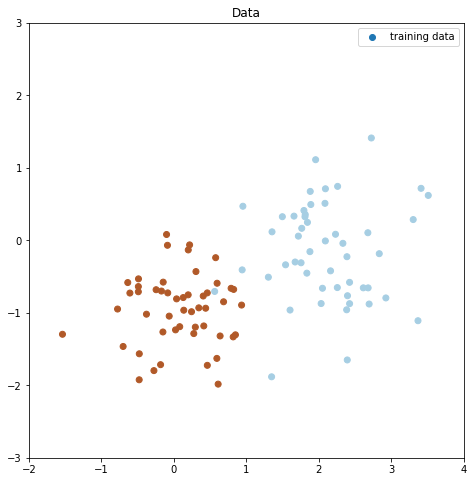

In [3]:
# Visualize the dummy dataset.

plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()

In [4]:


import functools
import itertools

def encode(y):
    """
    Encode class index into one-of-k code
    Parameters
    ----------
    class_indices : (N,) np.ndarray
        non-negative class index
        elements must be integer in [0, n_classes)
    Returns
    -------
    (N, K) np.ndarray
        one-of-k encoding of input
    """
    n_classes = np.max(y) + 1

    return np.eye(n_classes)[y]


def fit(X, y):
    """
    Least squares fitting for classification parameters.
    When y is class labels, least square is equivalent to LDA.
    ----------
    X : (N, D) np.ndarray
        training independent variable
    y : (N,) or (N, K) np.ndarray
        training dependent variable
        in class index (N,) or one-of-k coding (N,K)
    """
    if y.ndim == 1:
        y = encode(y)
    W = np.linalg.pinv(X) @ y
    return W


def classify(X, W):
    """
    Classify input data.
    ----------
    X : (N, D) np.ndarray
        independent variable to be classified
    W : (D,) or (D, K) np.ndarray
    -------
    Return
    (N,) np.ndarray
        class index for each input
    """
    return np.argmax(X @ W, axis=-1)

def transform(x, degree):
    # Transforms input array with polynomial features
    # x : (sample_size, n) ndarray
    # Output : (sample_size, 1 + nC1 + ... + nCd) ndarray

    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = []
    for degree in range(1, degree + 1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()



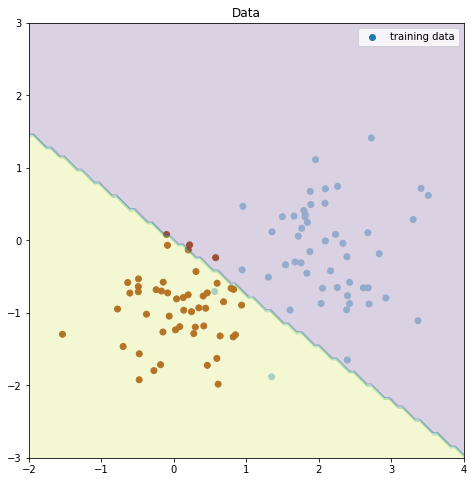

In [5]:
# Train the model by using function fit defined above, and then apply the trained model to predict everywhere in the input space X.

x1_test, x2_test = np.meshgrid(np.linspace(-2, 4, 100), np.linspace(-3, 3, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

X_train = transform(x_train, 1)
X_test = transform(x_test, 1)

weights = fit(X_train, y_train)
y = classify(X_test, weights)


# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 7))
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()


### Probabilistic Discriminative Models: Logistic regression


In [6]:


def sigmoid(a):
    return np.tanh(a * 0.5) * 0.5 + 0.5

def fit(X, y, max_iter=100):
    """
    maximum likelihood estimation of logistic regression model
    Parameters
    ----------
    X : (N, D) np.ndarray
        training data independent variable
    t : (N,) np.ndarray
        training data dependent variable
        binary 0 or 1
    max_iter : int, optional
        maximum number of paramter update iteration (the default is 100)
    """
    w = np.zeros(np.size(X, 1))
    for _ in range(max_iter):
        w_prev = np.copy(w)
        y_bar = sigmoid(X @ w)
        grad = X.T @ (y_bar - y)
        hessian = (X.T * y_bar * (1 - y_bar)) @ X
        try:
            w -= np.linalg.solve(hessian, grad)
        except np.linalg.LinAlgError:
            break
        if np.allclose(w, w_prev):
            break
    return w

def proba(X, W):
    """
    compute probability of input belonging class 1
    Parameters
    ----------
    X : (N, D) np.ndarray
        training data independent variable
    Returns
    -------
    (N,) np.ndarray
        probability of positive
    """
    return sigmoid(X @ W)

def classify(X, W, threshold=0.5):
    """
    classify input data
    Parameters
    ----------
    X : (N, D) np.ndarray
        independent variable to be classified
    threshold : float, optional
        threshold of binary classification (default is 0.5)
    Returns
    -------
    (N,) np.ndarray
        binary class for each input
    """
    return (proba(X, W) > threshold).astype(np.int)

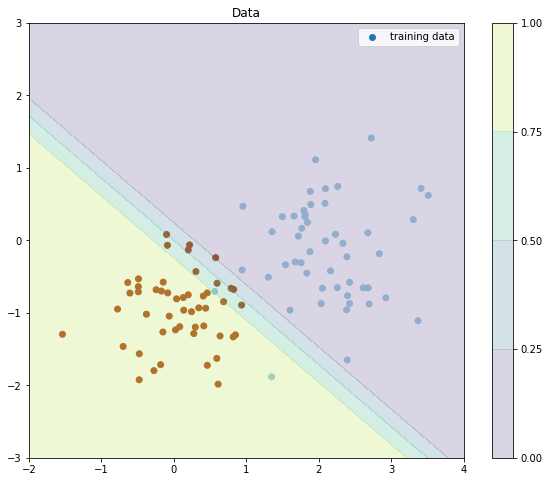

In [7]:


X_train = transform(x_train, 1)
X_test = transform(x_test, 1)

weights = fit(X_train, y_train)
y = proba(X_test, weights)

# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 5))
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.colorbar()
plt.legend()

### A non-statistical perspective: The Perceptron

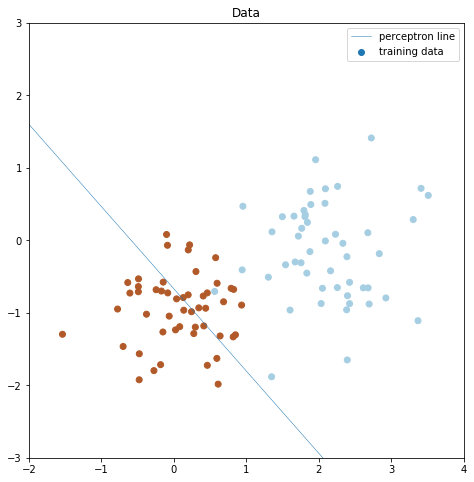

In [12]:


# Make a prediction with weights
def predict(point, weights):
    activation = np.dot(point, weights)
    return 1.0 if activation >= 0.0 else -1.0
 
# Estimate Perceptron weights using stochastic gradient descent
def train(x, y, l_rate, n_epoch):
    x = np.c_[np.ones(len(x))*(-1.0), x]
    weights = [0.0 for i in range(x.shape[1])]
    for epoch in range(n_epoch):
        for i, xi in enumerate(x):
            if predict(xi, weights)*y[i] <= 0:
                weights = weights + l_rate*xi*y[i]
    return weights


l_rate = 0.05
n_epoch = 100

weights = train(X_train, y_train*2-1, l_rate, n_epoch)

# Visualize the decision boundary/line.
# Given the weights, the decision line on the X plane can be defined by the function X*W = 0.
# Then the position of the decision line can be easily determined:
x1 = np.linspace(-3, 15, 200).reshape(-1,1)
x2 = (weights[0]+weights[1]*x1)/(-weights[2])

# Visualization
plt.figure(figsize=(10,8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
plt.plot(x1, x2, linewidth=.5, label='perceptron line')
plt.axis([-2, 4, -3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Data')
plt.legend()


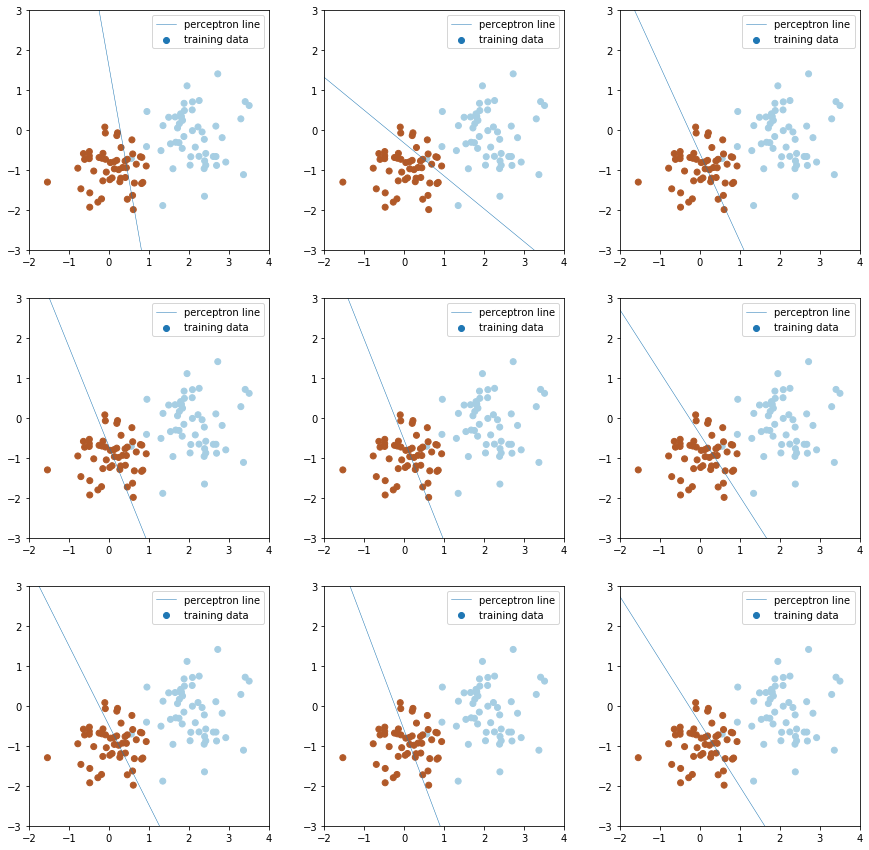

In [21]:
# You can even visualize how weights have been updated during some of the epochs.

# But first you need to re-write the training functionality to record trained weights in each epoch.
def train(x, y, l_rate, n_epoch):
    x = np.c_[np.ones(len(x))*(-1.0), x]
    weights_all = []
    weights = [0.0 for i in range(x.shape[1])]
    for epoch in range(n_epoch):
        for i, xi in enumerate(x):
            if predict(xi, weights)*y[i] <= 0:
                weights = weights + l_rate*xi*y[i]
                weights_all.append(weights)
    return weights_all

l_rate = 0.01
n_epoch = 100
weights_all = train(X_train, y_train*2-1, l_rate, n_epoch)


fig = plt.figure(figsize=(15,15))
for i in range(9):
    x1 = np.linspace(-3, 15, 200).reshape(-1,1)
    x2 = (weights_all[i*6][0]+weights_all[i*6][1]*x1)/(-weights_all[i*6][2])
    plt.subplot(3, 3, i+1)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='Paired', label='training data')
    plt.plot(x1, x2, linewidth=.5, label='perceptron line')
    plt.axis([-2, 4, -3, 3])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()

In [ ]:
# Perceptron Algorithm With Stochastic Gradient Descent
def perceptron(train, test, l_rate, n_epoch):
    predictions = list()
    weights = train(train, l_rate, n_epoch)
    for row in test:
        prediction = predict(row, weights)
        predictions.append(prediction)
    return(predictions)

In [ ]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0



In [ ]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# evaluate algorithm
n_folds = 3


scores = evaluate_algorithm(dataset, perceptron, n_folds, l_rate, n_epoch)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))